<a href="https://colab.research.google.com/github/achaterlea/london_data/blob/master/ACL_House_Price_Modelling_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# London house price modelling
Andy Chater-Lea

The goal of my project is to apply data science techniques to model house prices based on wider factors about an area which would indicate desirability - for example access to public transport, education, crime and healthcare statistics. I will perform local price modelling at Lower Super Output Area (LSOA) level of granularity. LSOAs are the smallest area unit of measurement used by the government in statistics publically hosted on the London datastore and office of national statistics websites. These areas were drawn geographically in the 2011 census to include ~600 dwellings. I will be using census data and other publically available data I have gathered about about London at this level of granularity as my predictor variables.

## 1. Data collection and preparation

In [1]:
#load relevant libraries for data exploration
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

%matplotlib inline

In [2]:
#Import census data and check the head. I will primarily be using census data from the most recent (2011) census.
df = pd.read_csv("LSOAdata11.csv", encoding = "ISO-8859-1")

In [3]:
#Set the LSOA as the index, and review data head
df.set_index(['LSOA'], inplace = True)
print (df.shape)
df.head()

(4835, 91)


,Name,All Ages,0-15,16-29,30-44,45-64,65+,Working-age,Working age %,Area (Hectares),...,Average PTAL Score,% 0-1 (poor access),% 2-3 (average access),% 4-6 (good access),Total Number of Children,Total Number of Families Claiming Benefit,Number of families with 3+ children,% of families with 3+ children,Mean Annual Household Income estimate,Median Annual Household Income estimate
LSOA,,,,,,,,,,,,,,,,,,,,,
E01000907,Camden 001A,1430,295,257,372,343,163,972,67.972,10.7,...,4.6,0.0,54.1,45.9,315,180,35,19.4,39985,30223
E01000908,Camden 001B,1581,292,240,431,407,211,1078,68.185,17.5,...,2.9,33.7,66.3,0.0,260,160,20,12.5,42394,32049
E01000909,Camden 001C,1614,244,291,328,462,289,1081,66.976,22.9,...,3.3,0.0,100.0,0.0,185,115,15,13.0,77370,58469
E01000912,Camden 001D,1589,260,356,352,395,226,1103,69.415,89.6,...,4.6,0.0,58.4,41.6,290,160,30,18.8,41737,31551
E01000913,Camden 001E,1710,292,220,343,522,333,1085,63.450,161.7,...,2.8,27.8,71.8,0.5,190,105,20,19.0,96649,73024


In [4]:
#I have also obtained land Registry data by LSOA detailing the makup of dwellings by type and size
df_landregistry = pd.read_csv("PropertyTypes.csv")
df_landregistry.set_index('LSOA', inplace = True)
print(df_landregistry.shape)
df_landregistry.head()

(4835, 56)


,NAME,TYPE_BUNGALOW_1,TYPE_BUNGALOW_2,TYPE_BUNGALOW_3,TYPE_BUNGALOW_4,TYPE_BUNGALOW_UNKW,BUNGALOW,TYPE_FLAT_MAIS_1,TYPE_FLAT_MAIS_2,TYPE_FLAT_MAIS_3,...,BP_1955_1964,BP_1965_1972,BP_1973_1982,BP_1983_1992,BP_1993_1999,BP_2000_2009,BP_2010_2015,BP_UNKNOWN,ALL_PROPERTIES.1,WAVG_AGE
LSOA,,,,,,,,,,,,,,,,,,,,,
E01000001,City of London 001A,0,0,0,0,0,0,450,350,210,...,50,840,10,0,50,80,0,10,1100,50.83
E01000002,City of London 001B,0,0,0,0,0,0,630,320,110,...,70,910,0,10,0,0,200,0,1190,43.70
E01000003,City of London 001C,0,0,0,0,0,0,540,240,20,...,20,780,0,0,60,40,0,0,910,48.58
E01000005,City of London 001E,0,0,0,0,0,0,330,200,130,...,140,110,170,70,0,10,70,0,680,54.18
E01000006,Barking and Dagenham 016A,0,0,0,0,0,0,90,50,0,...,0,0,0,0,130,10,0,0,530,74.72


In [5]:
df = df.join(df_landregistry, how = 'inner')
print (df.shape)

(4835, 147)


In [6]:
#I will also add in crime data I have obtained separately
df_crime = pd.read_csv("LSOA_Crime.csv")
df_crime = df_crime.set_index('LSOA')
print (df_crime.shape)
df_crime.head()

(124913, 13)


,Major Category,Crimes_2008,Crimes_2009,Crimes_2010,Crimes_2011,Crimes_2012,Crimes_2013,Crimes_2014,Crimes_2015,Crimes_2016,4_YRS_TO_2011,3_YRS_TO_2011,2_YRS_TO_2011
LSOA,,,,,,,,,,,,,
E01000001,Burglary,0,0,0,0,1,0,0,0,0,0,0,0
E01000001,Violence Against the Person,0,0,0,0,0,0,0,1,0,0,0,0
E01000001,Criminal Damage,0,0,0,0,0,1,0,0,0,0,0,0
E01000001,Drugs,0,0,0,0,0,0,0,1,0,0,0,0
E01000001,Violence Against the Person,0,0,0,0,0,0,0,1,0,0,0,0


In [7]:
#The crime data needs to be summarised by category - I will use 2011 data only for this pivot
df_crime = df_crime.pivot_table(columns='Major Category', values = ['Crimes_2011'], index = 'LSOA',  aggfunc='sum')
df_crime.columns = df_crime.columns.droplevel(level = 0) #fix column labels
df_crime['Total Crimes'] = df_crime.sum(axis = 1) #add a total column
df_crime = df_crime.fillna(value = 0) #replace NaNs with 0s
print(df_crime.shape)
df_crime.head()

(4835, 10)


Major Category,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person,Total Crimes
LSOA,,,,,,,,,,
E01000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
E01000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,7.0
E01000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E01000005,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,3.0,9.0
E01000006,18.0,4.0,10.0,0.0,1.0,10.0,0.0,41.0,15.0,99.0


In [8]:
df = df.join(df_crime, how = 'left')
print (df.shape)
df.head()

(4835, 157)


,Name,All Ages,0-15,16-29,30-44,45-64,65+,Working-age,Working age %,Area (Hectares),...,Burglary,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person,Total Crimes
LSOA,,,,,,,,,,,,,,,,,,,,,
E01000907,Camden 001A,1430,295,257,372,343,163,972,67.972,10.7,...,21.0,15.0,1.0,0.0,0.0,3.0,0.0,31.0,27.0,98.0
E01000908,Camden 001B,1581,292,240,431,407,211,1078,68.185,17.5,...,9.0,11.0,1.0,0.0,1.0,2.0,0.0,38.0,15.0,77.0
E01000909,Camden 001C,1614,244,291,328,462,289,1081,66.976,22.9,...,25.0,13.0,4.0,0.0,0.0,4.0,0.0,53.0,7.0,106.0
E01000912,Camden 001D,1589,260,356,352,395,226,1103,69.415,89.6,...,19.0,20.0,16.0,0.0,7.0,23.0,0.0,75.0,46.0,206.0
E01000913,Camden 001E,1710,292,220,343,522,333,1085,63.450,161.7,...,45.0,14.0,4.0,0.0,0.0,7.0,0.0,151.0,42.0,263.0


In [38]:
#Print full column names and indices to identify unwanted features 
print([z for z in zip(range(len(df.columns)), df.columns)])

[(0, 'Name'), (1, 'All Ages'), (2, '0-15'), (3, '16-29'), (4, '30-44'), (5, '45-64'), (6, '65+'), (7, 'Working-age'), (8, 'Working age %'), (9, 'Area (Hectares)'), (10, 'Persons per Hectare 2011'), (11, 'Number of households'), (12, 'Couple household with dependent children'), (13, 'Couple household without dependent children'), (14, 'Lone parent household'), (15, 'One person household'), (16, 'Other household Types'), (17, '% Couple household with dependent children'), (18, '% Couple household without dependent children'), (19, '% Lone parent household'), (20, '% One person household'), (21, '% Other multi person household'), (22, 'Owned outright'), (23, 'Owned with a mortgage or loan'), (24, 'Social rented'), (25, 'Private rented'), (26, 'Owned outright (%)'), (27, 'Owned with a mortgage or loan (%)'), (28, 'Social rented (%)'), (29, 'Private rented (%)'), (30, 'All Households'), (31, 'Household spaces with at least one usual resident'), (32, 'Household spaces with no usual residents

In [39]:
#The data contains prices from years 2009-2014 which i am ommitting as they are linked to my target variable
df = df.drop(df.columns[[43,44,46,47,48]], axis = 1)

## 2. EDA and feature engineering

Skew:  4.275245179593808 Kurtosis:  32.03828139091149


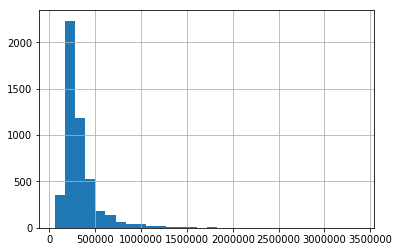

In [40]:
#Investigate the distribution of Median price 2011
df['Median price 2011'].hist(bins = 30)
print('Skew: ',skew(df['Median price 2011']),'Kurtosis: ',kurtosis(df['Median price 2011']))

In [41]:
#The data is very heavily right skewed, and also contains nil values which need to be omitted. 
#I will segment my population at 400,000 to focus my modelling on the bulk of the properties without the long tail
df = df[df['Median price 2011']!=0]
df_lower = df[df['Median price 2011']<=400000]
df_lower.shape

(3844, 152)

Skew:  0.29057798048330336 Kurtosis:  -0.6121749426408769


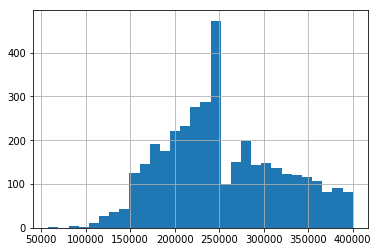

In [173]:
df_lower['Median price 2011'].hist(bins = 30)
print('Skew: ',skew(df_lower['Median price 2011']),'Kurtosis: ',kurtosis(df_lower['Median price 2011']))

The data is clearly not a normal distribution, however removing the tail has substantially fixed skewness to a weak positive. Kurtosis of -0.6 indicates that the distribution is flatter than a normal distribution which should have a kurtosis of +3.
Also - there is a significant step change at the £250k marks, this is due to the change in Stamp Duty from 1% to 3% at this threshold, so sellers are incentivised to list properties just below where this change in rate kicks in

# Follow up with Seun whether this is ok? Is there a simple transform to fix?
## Also see error message below

C:\Users\andyc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Skew:  0.00916777473638384 Kurtosis:  -0.5207274020192663


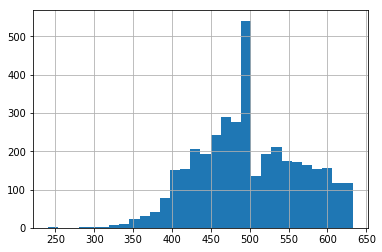

In [174]:
df_lower['Root price'] = np.sqrt(df_lower['Median price 2011'])
df_lower['Root price'].hist(bins = 30)
print('Skew: ',skew(df_lower['Root price']),'Kurtosis: ',kurtosis(df_lower['Root price']))

In [48]:
#Investigate which fields correlate to the target variable
print(np.abs(df_lower.corr()['Median price 2011']).sort_values(ascending = False).head(30))

Median price 2011                                                     1.000000
Root price                                                            0.996795
Mean Annual Household Income estimate                                 0.637806
Median Annual Household Income estimate                               0.605060
% Highest level of qualification: Level 4 qualifications and above    0.573077
Total Number of Families Claiming Benefit                             0.526394
% Highest level of qualification: Level 1 qualifications              0.511224
% Lone parent household                                               0.511183
Highest level of qualification: Level 4 qualifications and above      0.506697
% No qualifications                                                   0.498868
Total Number of Children                                              0.487202
Unemployment Rate                                                     0.478899
Highest level of qualification: Level 1 qualificatio

In [47]:
df_lower.describe()

,All Ages,0-15,16-29,30-44,45-64,65+,Working-age,Working age %,Area (Hectares),Persons per Hectare 2011,...,Criminal Damage,Drugs,Fraud or Forgery,Other Notifiable Offences,Robbery,Sexual Offences,Theft and Handling,Violence Against the Person,Total Crimes,Root price
count,3844.000000,3844.000000,3844.000000,3844.000000,3844.000000,3844.000000,3844.000000,3844.000000,3844.000000,3844.000000,...,3844.000000,3844.000000,3844.0,3844.000000,3844.000000,3844.0,3844.000000,3844.000000,3844.000000,3844.000000
mean,1709.577003,351.103798,389.830385,426.941467,357.158169,184.543184,1173.930021,68.520418,32.627758,93.786550,...,15.476327,11.649324,0.0,2.188345,7.829344,0.0,54.808793,31.693028,142.609781,499.054950
std,270.070458,103.566368,152.324449,115.619334,74.179758,75.969264,231.848366,5.983363,65.021572,58.720051,...,10.338568,16.940677,0.0,5.184939,8.294885,0.0,75.500196,29.709706,133.115690,65.915536
min,985.000000,43.000000,139.000000,171.000000,45.000000,4.000000,640.000000,49.401000,1.800000,1.200000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,240.831892
25%,1544.750000,282.000000,290.000000,344.000000,312.000000,131.000000,1018.750000,64.425500,14.000000,52.575000,...,9.000000,4.000000,0.0,0.000000,2.000000,0.0,24.000000,15.000000,79.000000,452.769257
50%,1672.000000,339.000000,359.000000,411.000000,358.000000,174.000000,1132.000000,67.467500,20.800000,81.200000,...,14.000000,8.000000,0.0,1.000000,6.000000,0.0,37.000000,26.000000,113.000000,496.235831
75%,1836.000000,410.000000,453.000000,491.000000,405.000000,228.000000,1290.000000,71.639000,31.600000,123.200000,...,20.000000,14.000000,0.0,3.000000,11.000000,0.0,59.000000,39.000000,162.000000,547.722558
max,4933.000000,896.000000,3022.000000,960.000000,725.000000,599.000000,4235.000000,94.319000,1579.700000,684.700000,...,156.000000,351.000000,0.0,264.000000,112.000000,0.0,1596.000000,549.000000,2671.000000,632.455532


In [181]:
#Define a custom function to bin all of the numerical columns into 'n' categories
def binning(df,list_n):
    df_binned = pd.DataFrame()
    for c in df.columns:
        if df[c].dtype != 'object':
            for n in list_n:
                df_binned[c+' ('+str(n)+'-binned)'] = pd.qcut(df[c],n,labels = False, duplicates = 'drop')
    return df_binned

In [182]:
df_binned = binning(df_lower,[5,10,20])
df_binned = df_binned.join(df['Median price 2011'], how = 'inner')
df_binned.head()

,All Ages (5-binned),All Ages (10-binned),All Ages (20-binned),0-15 (5-binned),0-15 (10-binned),0-15 (20-binned),16-29 (5-binned),16-29 (10-binned),16-29 (20-binned),30-44 (5-binned),...,Violence Against the Person (5-binned),Violence Against the Person (10-binned),Violence Against the Person (20-binned),Total Crimes (5-binned),Total Crimes (10-binned),Total Crimes (20-binned),Root price (5-binned),Root price (10-binned),Root price (20-binned),Median price 2011
LSOA,,,,,,,,,,,,,,,,,,,,,
E01000908,1,3,6,1,2,5,0,0,1,2,...,1,2,4,1,2,4,3,6,13,282500
E01000921,4,8,17,1,2,4,4,9,18,4,...,4,8,17,4,9,19,4,8,17,342495
E01000928,2,5,10,1,3,6,1,3,7,2,...,4,9,18,4,8,17,4,8,17,346500
E01000872,4,8,16,0,0,1,4,8,17,4,...,3,6,13,4,8,16,4,8,17,342475
E01000889,2,4,9,3,6,12,3,6,12,1,...,2,5,11,1,3,7,3,6,13,275000


In [183]:
#Investigate which fields correlate to the target variable
print(np.abs(df_binned.corr()['Median price 2011']).sort_values(ascending = False).head(30))

Median price 2011                                                                 1.000000
Root price (20-binned)                                                            0.984262
Median price 2011 (20-binned)                                                     0.984262
Median price 2011 (10-binned)                                                     0.977298
Root price (10-binned)                                                            0.977298
Root price (5-binned)                                                             0.957806
Median price 2011 (5-binned)                                                      0.957806
Mean Annual Household Income estimate (20-binned)                                 0.639452
Mean Annual Household Income estimate (10-binned)                                 0.638274
Mean Annual Household Income estimate (5-binned)                                  0.623177
Median Annual Household Income estimate (20-binned)                               0.599174

In [113]:
df_binned.head()

,test,test2
LSOA,,
E01000907,8,8
E01000908,5,5
E01000909,8,8
E01000912,8,8
E01000913,9,9
